In [1]:
# =========================================
# Jupyter Notebook: RR results plotting
# IMPORTANT CHANGE:
#   - ALL line/scatter plots IGNORE runs where cores == 4
#   - ONLY the final 2 barplots include the (cores == 4) configuration(s)
# Reads: summary_results_enriched.json (in current directory)
# Uses: pandas + matplotlib only (no seaborn), no manual colors, no subplots.
# =========================================

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline


In [2]:
# -------------------------
# 1) Load + flatten JSON
# -------------------------
json_path = Path("summary_results_enriched.json")
assert json_path.exists(), f"Missing {json_path.resolve()}"

with json_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

df_all = pd.json_normalize(data, sep=".")
df_all.head()


,id,dataset,machines,cores,quantum_ms,total_time_to_run.sim_makespan_ms,total_time_to_run.estimated_wall_seconds,fairness.jobs,fairness.max_arrival_time_ms,fairness.sim_makespan_ms,...,fairness.slowdown_p50,fairness.slowdown_p95,fairness.slowdown_p99,fairness.slowdown_max,fairness.slowdown_cv,fairness.slowdown_gini,fairness.slowdown_jain,sources.jobs_csv,sources.run_csv,sources.directory
0,0048287ba9,small,2,2,20,14738000.0,7.369,1000,0.0,14738000.0,...,212100.000000,1.253383e+06,2.246390e+06,2.786000e+06,1.141873,0.519958,0.434052,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
1,009e310875,large,16,2,10,241764000.0,120.882,1000,0.0,241764000.0,...,371786.028331,4.257559e+05,5.274504e+05,6.878571e+05,0.150331,0.080818,0.977900,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
2,04f543ac28,large,8,2,500,67000000.0,3.350,1000,0.0,67000000.0,...,77358.537292,1.320227e+05,1.338658e+06,4.027500e+06,2.133339,0.468044,0.180143,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
3,08a78e0c55,large,16,2,20,105174000.0,52.587,1000,0.0,105174000.0,...,160858.691735,1.779823e+05,2.363718e+05,3.745000e+05,0.151913,0.076563,0.977443,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
4,135267c06e,medium,8,4,200,56440000.0,2.822,1000,0.0,56440000.0,...,250626.780627,2.501722e+06,4.785404e+06,8.166667e+06,1.737249,0.617745,0.248878,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...


In [3]:
# -------------------------
# 2) Cleanup + derived columns
# -------------------------
for col in ["id", "dataset", "machines", "cores", "quantum_ms"]:
    if col not in df_all.columns:
        df_all[col] = np.nan

# numeric
df_all["machines"] = pd.to_numeric(df_all["machines"], errors="coerce")
df_all["cores"]    = pd.to_numeric(df_all["cores"], errors="coerce")
df_all["quantum_ms"] = pd.to_numeric(df_all["quantum_ms"], errors="coerce")

df_all["total_slots"] = df_all["machines"] * df_all["cores"]

# time fields (prefer enriched)
if "total_time_to_run.sim_makespan_ms" not in df_all.columns:
    df_all["total_time_to_run.sim_makespan_ms"] = np.nan
if "fairness.speedup" not in df_all.columns:
    df_all["fairness.speedup"] = np.nan
if "total_time_to_run.estimated_wall_seconds" not in df_all.columns:
    df_all["total_time_to_run.estimated_wall_seconds"] = np.nan

df_all["total_time_to_run.sim_makespan_ms"] = pd.to_numeric(df_all["total_time_to_run.sim_makespan_ms"], errors="coerce")
df_all["fairness.speedup"] = pd.to_numeric(df_all["fairness.speedup"], errors="coerce")
df_all["total_time_to_run.estimated_wall_seconds"] = pd.to_numeric(df_all["total_time_to_run.estimated_wall_seconds"], errors="coerce")

# Fill wall time if missing: wall_s = sim_ms / speedup / 1000
mask_missing_wall = df_all["total_time_to_run.estimated_wall_seconds"].isna()
df_all.loc[mask_missing_wall, "total_time_to_run.estimated_wall_seconds"] = (
    df_all.loc[mask_missing_wall, "total_time_to_run.sim_makespan_ms"]
    / df_all.loc[mask_missing_wall, "fairness.speedup"]
    / 1000.0
)

# Optional throughput
if "fairness.jobs" in df_all.columns:
    df_all["fairness.jobs"] = pd.to_numeric(df_all["fairness.jobs"], errors="coerce")
    df_all["throughput_jobs_per_s"] = df_all["fairness.jobs"] / df_all["total_time_to_run.estimated_wall_seconds"]

# Normalize dataset label
df_all["dataset"] = df_all["dataset"].astype(str).str.lower().str.strip()

# Drop unusable rows
df_all = df_all.dropna(subset=["id", "dataset", "machines", "cores", "quantum_ms", "total_slots", "total_time_to_run.estimated_wall_seconds"])
df_all = df_all[df_all["total_time_to_run.estimated_wall_seconds"] > 0]

# Ensure one row per run_id (id is unique per run)
df_all = df_all.drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)

df_all[["id","dataset","machines","cores","total_slots","quantum_ms","total_time_to_run.estimated_wall_seconds"]].head()


,id,dataset,machines,cores,total_slots,quantum_ms,total_time_to_run.estimated_wall_seconds
0,0048287ba9,small,2,2,4,20,7.369
1,009e310875,large,16,2,32,10,120.882
2,04f543ac28,large,8,2,16,500,3.350
3,08a78e0c55,large,16,2,32,20,52.587
4,135267c06e,medium,8,4,32,200,2.822


In [4]:
# -------------------------
# 3) Filter for MAIN plots: EXCLUDE cores == 4
# -------------------------
df = df_all[df_all["cores"] != 4].copy()
df = df.sort_values(["dataset", "total_slots", "quantum_ms"]).reset_index(drop=True)

print("Rows total:", len(df_all))
print("Rows used in main plots (cores != 4):", len(df))
print("Unique cores in main plots:", sorted(df["cores"].unique()))


Rows total: 72
Rows used in main plots (cores != 4): 54
Unique cores in main plots: [np.int64(2)]


In [5]:
# -------------------------
# 4) Plot helpers
# -------------------------
def dataset_values(dframe: pd.DataFrame):
    vals = [d for d in dframe["dataset"].dropna().unique() if d not in ("nan", "")]
    return sorted(vals)

def plot_lines_by_group(dframe: pd.DataFrame, x: str, y: str, group: str,
                        title: str, xlabel: str, ylabel: str,
                        logx: bool=False, logy: bool=False):
    plt.figure()
    for g, sub in dframe.groupby(group):
        sub = sub.dropna(subset=[x, y]).sort_values(x)
        if len(sub) == 0:
            continue
        plt.plot(sub[x], sub[y], marker="o", label=str(g))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title=group, loc="best")
    plt.show()

def plot_scatter(dframe: pd.DataFrame, x: str, y: str,
                 title: str, xlabel: str, ylabel: str,
                 logx: bool=False, logy: bool=False):
    plt.figure()
    sub = dframe.dropna(subset=[x, y])
    plt.scatter(sub[x], sub[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


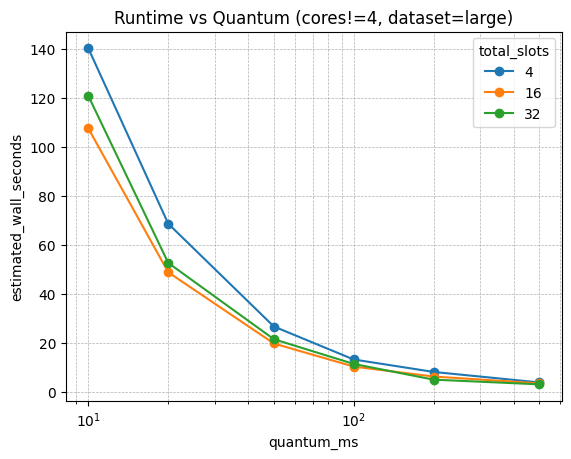

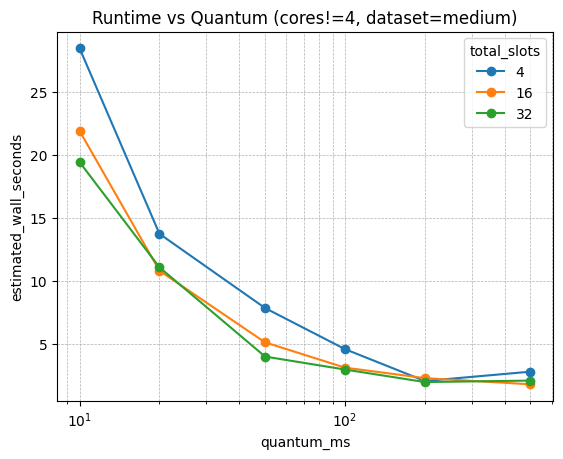

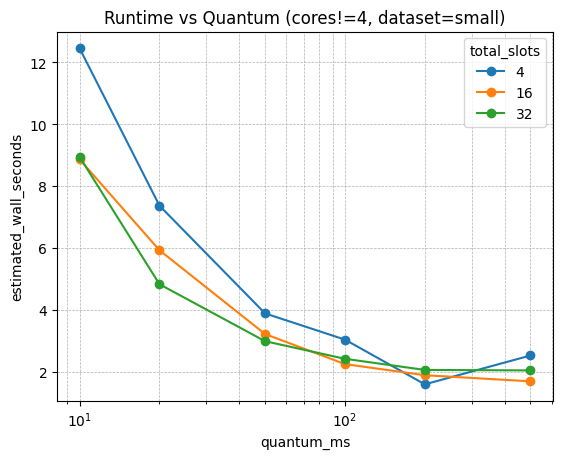

In [6]:
# -------------------------
# 5) A) Runtime vs quantum (per dataset), line per total_slots
# -------------------------
for ds in dataset_values(df):
    sub = df[df["dataset"] == ds]
    plot_lines_by_group(
        sub,
        x="quantum_ms",
        y="total_time_to_run.estimated_wall_seconds",
        group="total_slots",
        title=f"Runtime vs Quantum (cores!=4, dataset={ds})",
        xlabel="quantum_ms",
        ylabel="estimated_wall_seconds",
        logx=True
    )


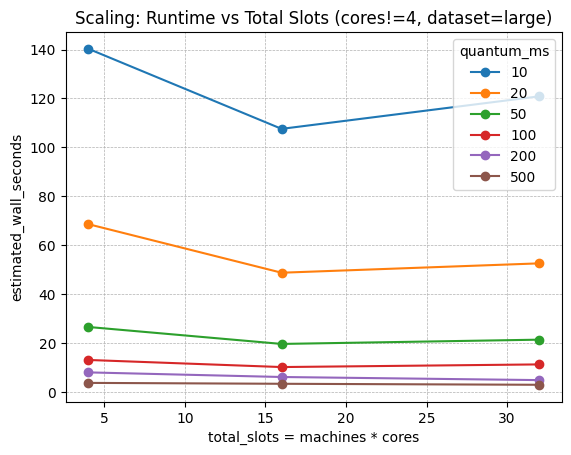

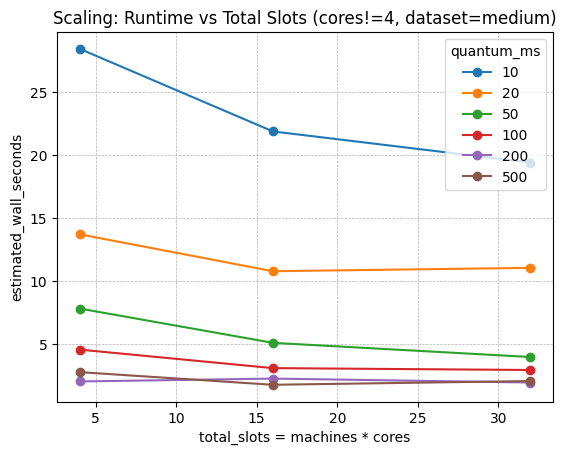

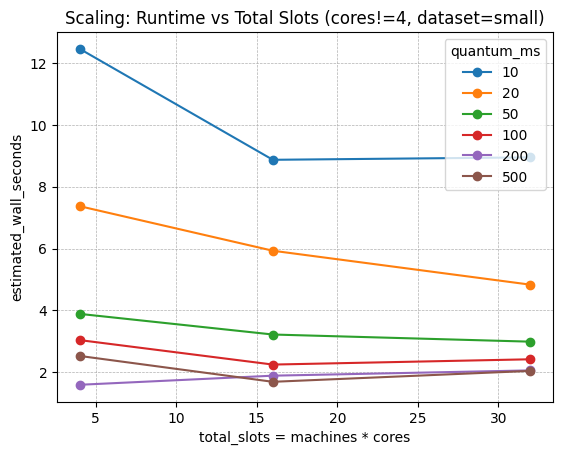

In [7]:
# -------------------------
# 6) B) Scaling: runtime vs total_slots, line per quantum
# -------------------------
for ds in dataset_values(df):
    sub = df[df["dataset"] == ds]
    plot_lines_by_group(
        sub,
        x="total_slots",
        y="total_time_to_run.estimated_wall_seconds",
        group="quantum_ms",
        title=f"Scaling: Runtime vs Total Slots (cores!=4, dataset={ds})",
        xlabel="total_slots = machines * cores",
        ylabel="estimated_wall_seconds"
    )


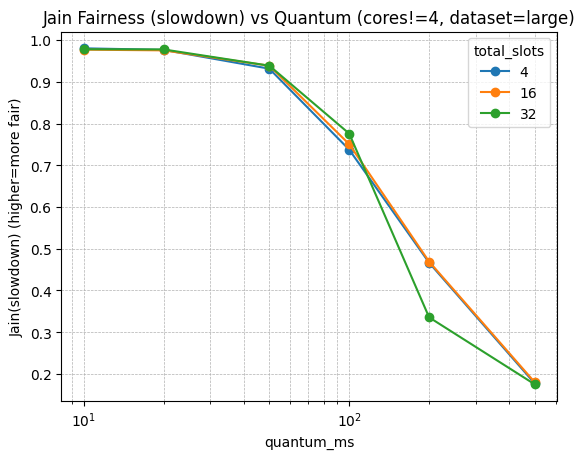

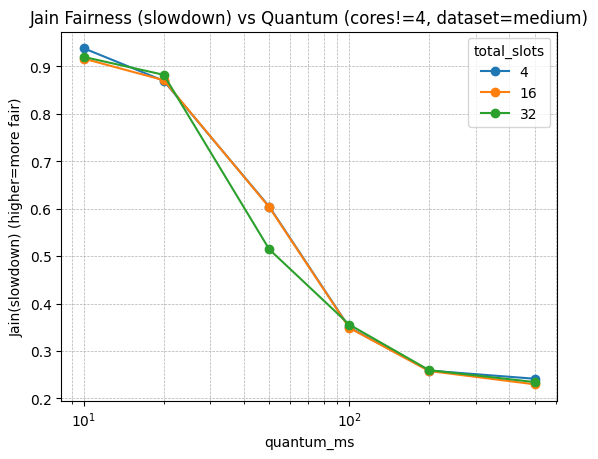

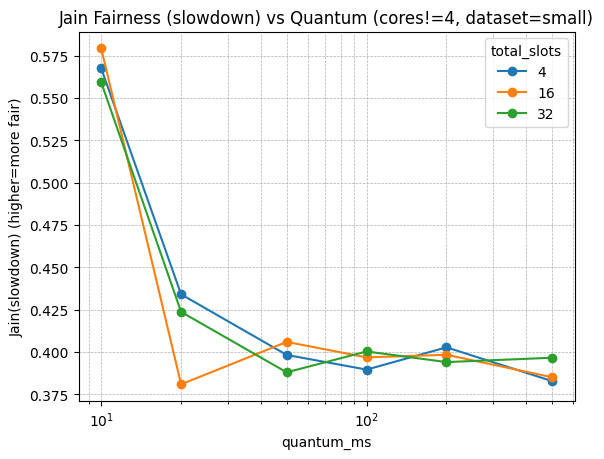

In [8]:
# -------------------------
# 7) C) Fairness vs quantum (Jain slowdown), line per total_slots
# -------------------------
if "fairness.slowdown_jain" in df.columns and df["fairness.slowdown_jain"].notna().any():
    df["fairness.slowdown_jain"] = pd.to_numeric(df["fairness.slowdown_jain"], errors="coerce")
    for ds in dataset_values(df):
        sub = df[df["dataset"] == ds]
        plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.slowdown_jain",
            group="total_slots",
            title=f"Jain Fairness (slowdown) vs Quantum (cores!=4, dataset={ds})",
            xlabel="quantum_ms",
            ylabel="Jain(slowdown) (higher=more fair)",
            logx=True
        )
else:
    print("Missing fairness.slowdown_jain in JSON; skipping Jain plots.")


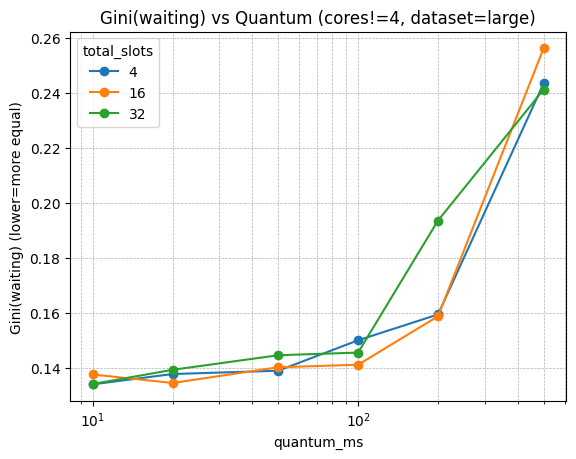

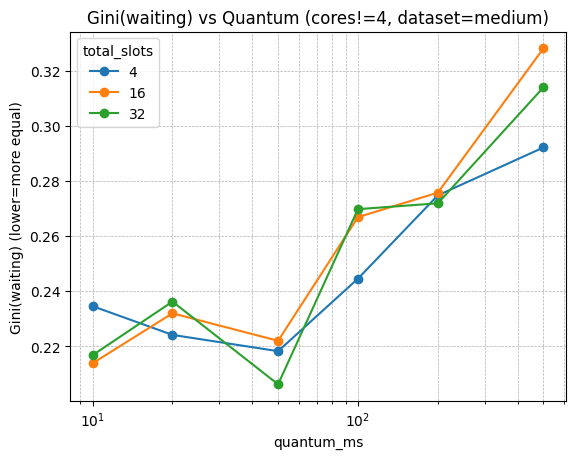

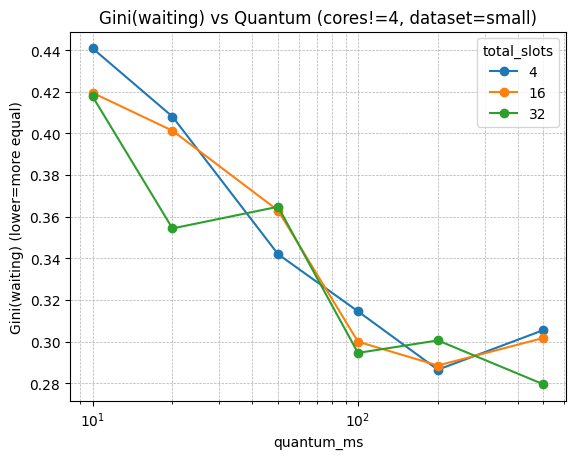

In [9]:
# -------------------------
# 8) D) Inequality vs quantum (Gini waiting), line per total_slots
# -------------------------
if "fairness.waiting_gini" in df.columns and df["fairness.waiting_gini"].notna().any():
    df["fairness.waiting_gini"] = pd.to_numeric(df["fairness.waiting_gini"], errors="coerce")
    for ds in dataset_values(df):
        sub = df[df["dataset"] == ds]
        plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.waiting_gini",
            group="total_slots",
            title=f"Gini(waiting) vs Quantum (cores!=4, dataset={ds})",
            xlabel="quantum_ms",
            ylabel="Gini(waiting) (lower=more equal)",
            logx=True
        )
else:
    print("Missing fairness.waiting_gini in JSON; skipping waiting Gini plots.")


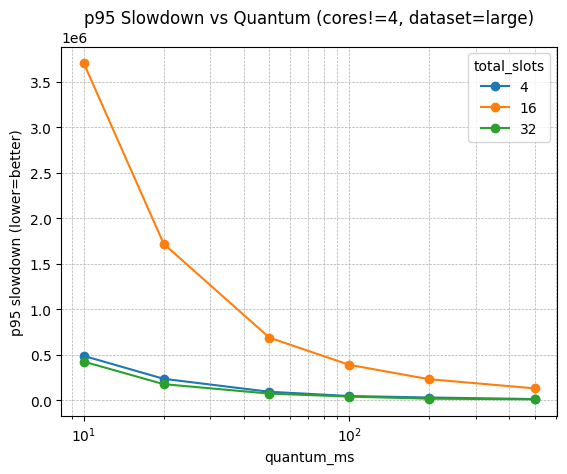

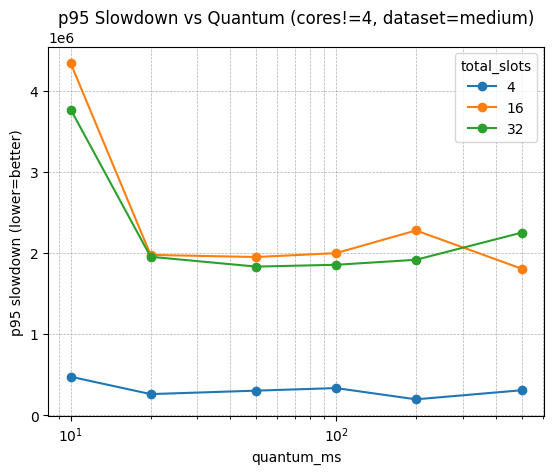

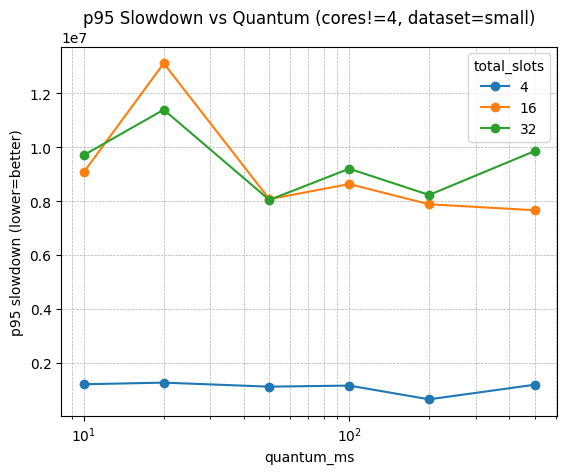

In [10]:
# -------------------------
# 9) E) Tail metric vs quantum: p95 slowdown, line per total_slots
# -------------------------
if "fairness.slowdown_p95" in df.columns and df["fairness.slowdown_p95"].notna().any():
    df["fairness.slowdown_p95"] = pd.to_numeric(df["fairness.slowdown_p95"], errors="coerce")
    for ds in dataset_values(df):
        sub = df[df["dataset"] == ds]
        plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.slowdown_p95",
            group="total_slots",
            title=f"p95 Slowdown vs Quantum (cores!=4, dataset={ds})",
            xlabel="quantum_ms",
            ylabel="p95 slowdown (lower=better)",
            logx=True
        )
else:
    print("Missing fairness.slowdown_p95 in JSON; skipping p95 slowdown plots.")


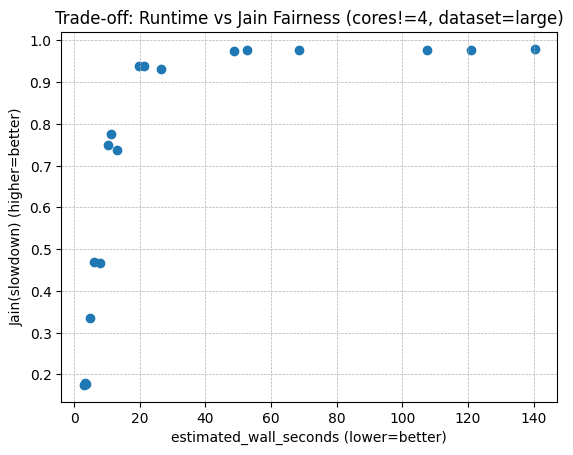

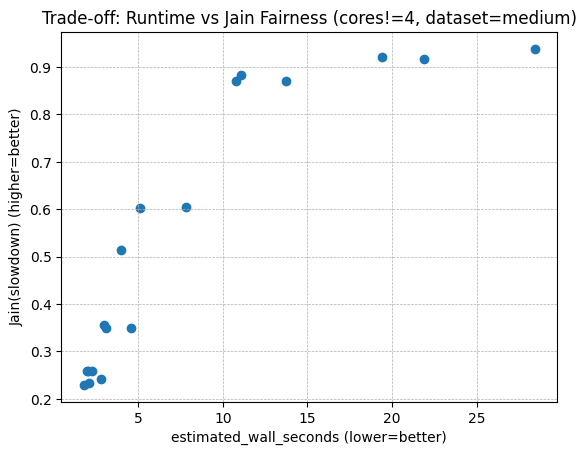

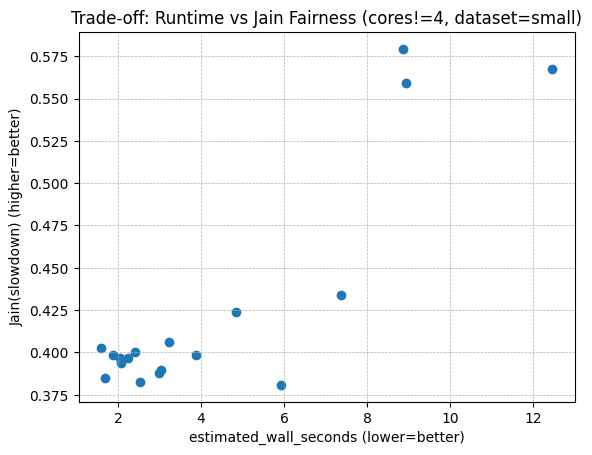

In [11]:
# -------------------------
# 10) F) Trade-off scatter: runtime vs Jain fairness (per dataset)
# -------------------------
if "fairness.slowdown_jain" in df.columns and df["fairness.slowdown_jain"].notna().any():
    for ds in dataset_values(df):
        sub = df[df["dataset"] == ds]
        plot_scatter(
            sub,
            x="total_time_to_run.estimated_wall_seconds",
            y="fairness.slowdown_jain",
            title=f"Trade-off: Runtime vs Jain Fairness (cores!=4, dataset={ds})",
            xlabel="estimated_wall_seconds (lower=better)",
            ylabel="Jain(slowdown) (higher=better)"
        )


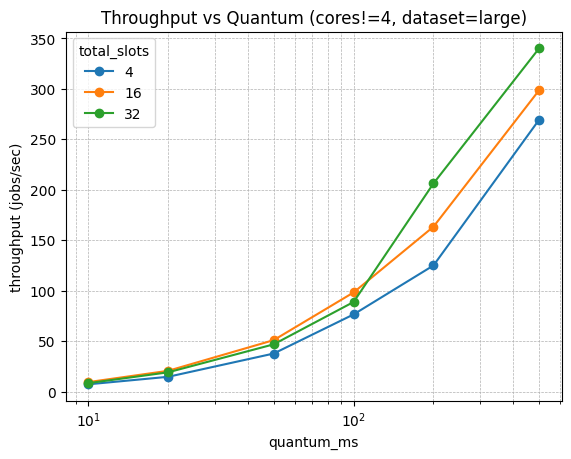

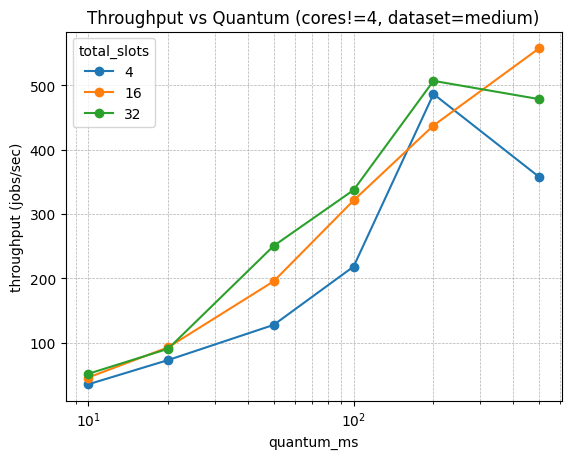

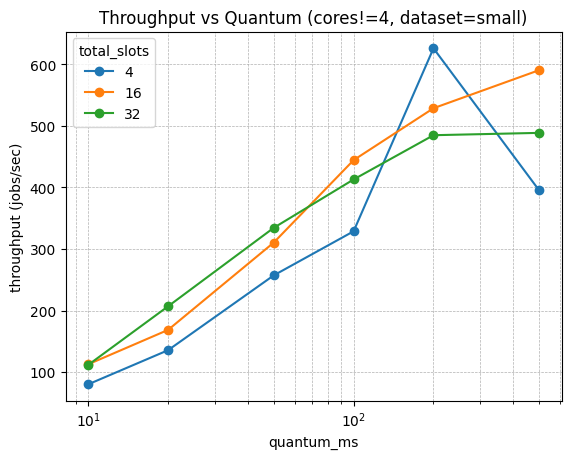

In [12]:
# -------------------------
# 11) G) Throughput vs quantum (per dataset), line per total_slots
# -------------------------
if "throughput_jobs_per_s" in df.columns and df["throughput_jobs_per_s"].notna().any():
    for ds in dataset_values(df):
        sub = df[df["dataset"] == ds]
        plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="throughput_jobs_per_s",
            group="total_slots",
            title=f"Throughput vs Quantum (cores!=4, dataset={ds})",
            xlabel="quantum_ms",
            ylabel="throughput (jobs/sec)",
            logx=True
        )
else:
    print("No throughput data available; skipping throughput plots.")


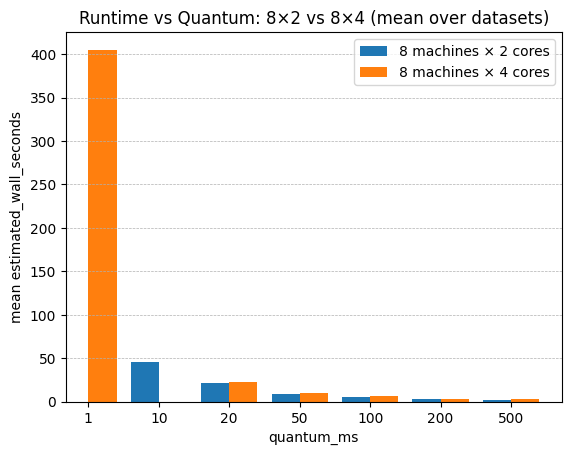

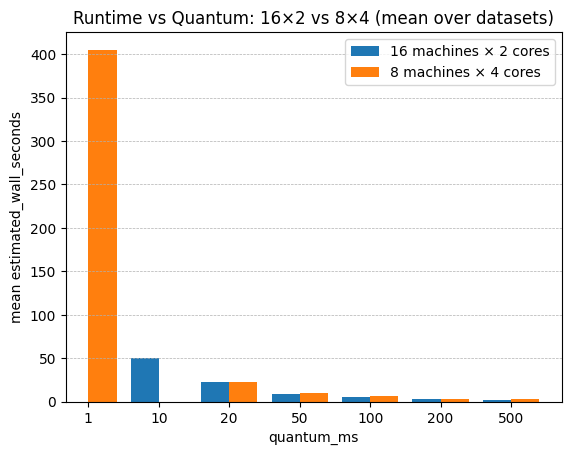

In [13]:
# ============================================================
# FINAL 2 BARPLOTS (these ARE allowed to include cores == 4)
#   1) Compare 8 machines 2 cores  vs  8 machines 4 cores
#   2) Compare 16 machines 2 cores vs  8 machines 4 cores
#
# These barplots compare runtime across quantum_ms.
# By default, we average across ALL datasets.
# If you want per-dataset, filter df_all[df_all["dataset"]=="small"] etc.
# ============================================================

def grouped_barplot_runtime_by_quantum(dframe: pd.DataFrame, configs: list[dict], title: str):
    """
    configs: list of dicts like {"machines": 8, "cores": 2, "label": "8m x 2c"}
    Bars are grouped by quantum_ms, with one bar per config.
    Runtime is mean estimated_wall_seconds across matching rows.
    """
    # Build a table: index=quantum_ms, columns=label, values=mean runtime
    parts = []
    for cfg in configs:
        sub = dframe[(dframe["machines"] == cfg["machines"]) & (dframe["cores"] == cfg["cores"])].copy()
        if len(sub) == 0:
            continue
        agg = sub.groupby("quantum_ms", as_index=False)["total_time_to_run.estimated_wall_seconds"].mean()
        agg["label"] = cfg["label"]
        parts.append(agg)

    if not parts:
        print("No data matched configs:", configs)
        return

    long = pd.concat(parts, ignore_index=True)
    pivot = long.pivot_table(
        index="quantum_ms",
        columns="label",
        values="total_time_to_run.estimated_wall_seconds",
        aggfunc="mean"
    ).sort_index()

    labels = list(pivot.columns)
    quanta = pivot.index.to_numpy()
    x = np.arange(len(quanta))

    plt.figure()
    width = 0.8 / max(1, len(labels))

    for i, lab in enumerate(labels):
        y = pivot[lab].to_numpy()
        plt.bar(x + i*width, y, width=width, label=str(lab))

    plt.title(title)
    plt.xlabel("quantum_ms")
    plt.ylabel("mean estimated_wall_seconds")
    plt.xticks(x + width*(len(labels)-1)/2, [str(int(q)) if float(q).is_integer() else str(q) for q in quanta], rotation=0)
    plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
    plt.legend(loc="best")
    plt.show()


# BARPLOT 1: 8 machines 2 cores vs 8 machines 4 cores
grouped_barplot_runtime_by_quantum(
    df_all,
    configs=[
        {"machines": 8, "cores": 2, "label": "8 machines × 2 cores"},
        {"machines": 8, "cores": 4, "label": "8 machines × 4 cores"},
    ],
    title="Runtime vs Quantum: 8×2 vs 8×4 (mean over datasets)"
)

# BARPLOT 2: 16 machines 2 cores vs 8 machines 4 cores
grouped_barplot_runtime_by_quantum(
    df_all,
    configs=[
        {"machines": 16, "cores": 2, "label": "16 machines × 2 cores"},
        {"machines": 8,  "cores": 4, "label": "8 machines × 4 cores"},
    ],
    title="Runtime vs Quantum: 16×2 vs 8×4 (mean over datasets)"
)
